<a href="https://colab.research.google.com/github/Gooogr/YOLO_Toolkit/blob/master/Minimal_tf_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on https://github.com/hunglc007/tensorflow-yolov4-tflite

In [1]:
import numpy as np
import fileinput
import urllib.request
import colorsys
import random

import cv2
from google.colab.patches import cv2_imshow

from tensorflow.python.saved_model import tag_constants
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


In [2]:
IS_TINY = True                               # Use YOLOv4 or Tiny YOLOv4 
MODEL_PATH = None                               # Specify url path to your .pb weights from converter. 
                                             # By default - example weights from project repository
CLASS_NAMES = ['Human face', 'Human hand']   # Specify your Imagenetv4 labels. By default - example 
                                             # labels corresponded to example weights 
INPUT_SIZE = None                            # Specify, if you use custom image size during the training.
                                             # By default - 416 for Tiny YOLO and 608 for YOLO

IOU_THRESHOLD = 0.45
SCORE_THRESHOLD = 0.25

In [3]:
# Image sample URL
IMG_URL = 'https://media.istockphoto.com/photos/smiling-medical-team-standing-together-outside-a-hospital-picture-id998313080?k=6&m=998313080&s=612x612&w=0&h=f6OoXoioX2AwfDal-0Ey8fw2YnzJVuUkjyht5m62hTM='

In [4]:
if MODEL_PATH is None:
    MODEL_PATH = 'https://github.com/Gooogr/YOLO_Toolkit/raw/master/sample_tiny_weights/checkpoints.zip'

In [5]:
# This code assumes that you got your model from Convert_YOLO2TF.ipynb
! wget --quiet $MODEL_PATH -O model.zip
! unzip -q model.zip
! ls -l /content/checkpoints

total 2600
drwxr-xr-x 2 root root    4096 Sep 14  2020 assets
-rw-r--r-- 1 root root 2650211 Sep 14  2020 saved_model.pb
drwxr-xr-x 2 root root    4096 Sep 14  2020 variables


### Utils

In [6]:
def url_to_image(url, save_path=None):
    '''
    Download the image by url-link, convert it to a NumPy array. Encode it into OpenCV format.
    input:
        url - direct url link to image 
    output:
        OpenCV image.
    '''
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")

    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    if save_path is not None:
        cv2.imwrite(save_path, image)
    else:
        return image

In [7]:
# Prepare the model
saved_model_loaded = tf.saved_model.load('/content/checkpoints', tags=[tag_constants.SERVING])
infer = saved_model_loaded.signatures['serving_default']

In [8]:
if INPUT_SIZE is None:
    INPUT_SIZE = 416  #ONLY TINY CASE!!!

In [9]:
# Prepare image for the model input
url_to_image(IMG_URL, 'sample_img.jpg')


original_image = cv2.imread('sample_img.jpg')
#original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image_data = cv2.resize(original_image, (INPUT_SIZE, INPUT_SIZE))
image_data = image_data / 255.
image_data = np.expand_dims(image_data, axis = 0).astype(np.float32)

In [10]:
# run infer and get bboxes with conf 
batch_data = tf.constant(image_data)
pred_bbox = infer(batch_data)
for key, value in pred_bbox.items():
    boxes = value[:, :, 0:4]
    pred_conf = value[:, :, 4:]

In [11]:
# perform non-max supression
boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
    boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
    scores=tf.reshape(
        pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
    max_output_size_per_class=50,
    max_total_size=50,
    iou_threshold=IOU_THRESHOLD,
    score_threshold=SCORE_THRESHOLD
)

pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]

In [12]:
def draw_bbox(image, bboxes, classes=CLASS_NAMES, show_label=True):
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    out_boxes, out_scores, out_classes, num_boxes = bboxes
    for i in range(num_boxes[0]):
        if int(out_classes[0][i]) < 0 or int(out_classes[0][i]) > num_classes: continue
        coor = out_boxes[0][i]
        coor[0] = int(coor[0] * image_h)
        coor[2] = int(coor[2] * image_h)
        coor[1] = int(coor[1] * image_w)
        coor[3] = int(coor[3] * image_w)

        fontScale = 0.5
        score = out_scores[0][i]
        class_ind = int(out_classes[0][i])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[1], coor[0]), (coor[3], coor[2])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick // 2)[0]
            c3 = (c1[0] + t_size[0], c1[1] - t_size[1] - 3)
            cv2.rectangle(image, c1, (np.float32(c3[0]), np.float32(c3[1])), bbox_color, -1) #filled

            cv2.putText(image, bbox_mess, (c1[0], np.float32(c1[1] - 2)), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick // 2, lineType=cv2.LINE_AA)
    return image

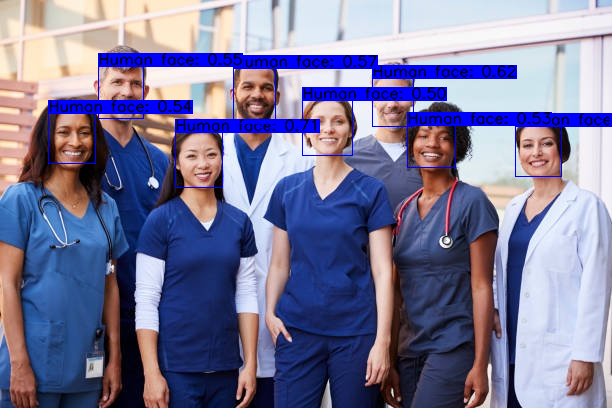

In [13]:
# draw result
image = draw_bbox(original_image, pred_bbox)
cv2_imshow(image)

In [14]:
######################################